# Image processing pipeline on representative bone marrow sample

This notebook gives an overview of all steps of the image processing pipeline applied to one representative bone marrow sample. 

## Loading multiplex IF and IMC images

First, we read the raw 3-plex IF and 44-plex (including calibration channels) IMC images (compressed into h5 files). The nomenclature of the files is as follows:
- sample folder: staining-data_IMC-date_sample-ID_tissue-type

Large IF images were generated (roughly 9,000 x 9,000 px) to account for the offset between IF and IMC measurements. IMC images have an initial size of 700 x 700 px, but are cropped by 2 pixel to eliminate ablation artifacts on image borders yielding a final size of 696 x 696 pixels. 

`path2test_data` has to be defined below and points to the directory, to which the MapMetIP_TestDataset from Zenodo was downloaded. 

In [2]:
from MapMetIP.sample import MapMetIP_Sample
from pathlib import Path
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import os

#Directory of MapMetIP_TestDataset
path2test_data = "/data"

data_path = Path(path2test_data).joinpath("MapMetIP_TestDataset/BM")
sample_name = "20220727_20220222_16-063_BM.h5"

sample_folder = data_path.joinpath(sample_name)
sample = MapMetIP_Sample(sample_folder)

#select ROI for visualization
roi=1 

IF = sample.mod0[roi]
IMC = sample.mod1[roi]

clear_output()
print("The", IF.image_stack.shape[0],"- plex IF images have a size of ",IF.image_stack.shape[1]," x " ,IF.image_stack.shape[2]," px.")
print("The", IMC.image_stack.shape[0],"- plex IMC images have a size of ",IMC.image_stack.shape[1]," x " ,IMC.image_stack.shape[2]," px.")


The 3 - plex IF images have a size of  8704  x  9728  px.
The 44 - plex IMC images have a size of  696  x  696  px.


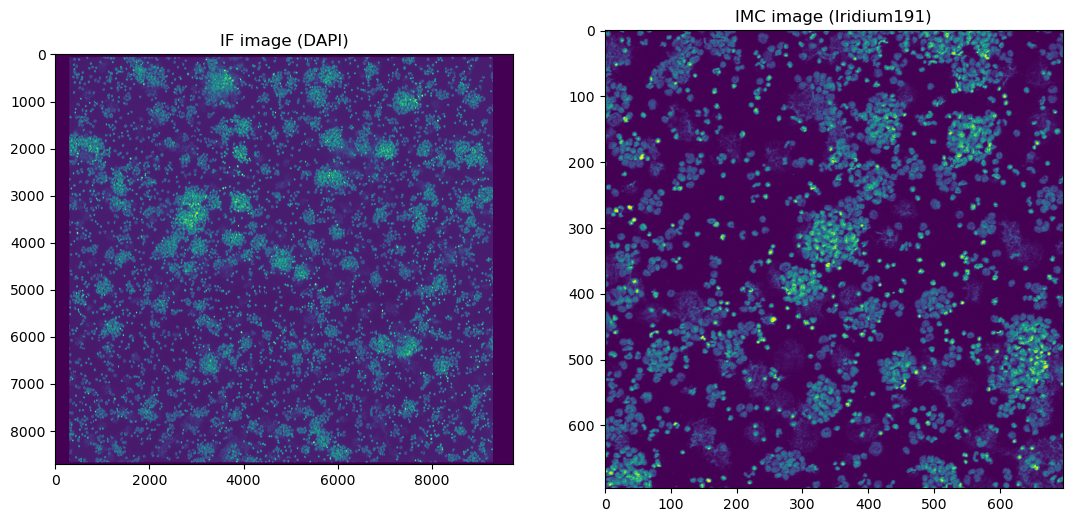

In [3]:
#select IF channel to visualize
channel_IF="IF1_DAPI"

#select IMC channel to visualize
channel_IMC="DNA1_Ir191"

#plot images
channel_idx = np.where(IF.stack_channels==channel_IF)[0][0]
IF_nuclear_image = IF.image_stack[channel_idx]

channel_idx = np.where(IMC.stack_channels==channel_IMC)[0][0]
IMC_image = IMC.image_stack[channel_idx]

fig, ax = plt.subplots(1, 2, figsize=(13, 13))
ax[0].imshow(IF_nuclear_image)
ax[1].imshow(np.clip(IMC_image, 0, np.percentile(IMC_image, 99.9))) # clipping for better visualization

ax[0].set_title('IF image (DAPI)')
ax[1].set_title('IMC image (Iridium191)')

plt.show()

## Segmentation based on nuclear IF image

For segmentation, we use our finetuned cellpose model on the high-resolution nuclear IF image. Cellpose requires the definition of an average nuclear diameter (``segmentation_diameter``) in pixels. For BM samples, which contain a high number of segmented nuclei (e.g. in neutrophils), we refine masks upon segmentation by zeroing the mask where the corresponding DAPI image falls below a defined threshold (``refine_threshold``). 

`path2model` has to be defined below and points to the directory, to which the MapMetIP_models from Zenodo was downloaded. 

In [4]:
from MapMetIP.segmentation import Segmenter

#Directory of MapMetIP_models
path2model = "/data"

model_path = Path(path2model).joinpath("MapMetIP_models")

segmenter = Segmenter(model_path.joinpath("BM/segmentation_model/CP_BM"))

segmentation_diameter = 55
refine_threshold = 0.12

segmentation_masks, refined_segmentation_masks = segmenter.segment(
    IF_nuclear_image.squeeze(), 
    eval_kwargs={"diameter": segmentation_diameter},
    refine_threshold=refine_threshold)

Exception: Model /data/MapMetIP_models/BM/segmentation_model/CP_BM does not exist!

In [ ]:
from cellplot.segmentation import rand_col_seg
from cellplot import gridPlot

IF_nuclear_image_zoom = IF_nuclear_image[3000:4000, 3000:4000]
segmentation_mask_zoom = segmentation_masks[3000:4000, 3000:4000]
refined_segmentation_mask_zoom = refined_segmentation_masks[3000:4000, 3000:4000]

images = [IF_nuclear_image, rand_col_seg(segmentation_masks), rand_col_seg(refined_segmentation_masks), 
          IF_nuclear_image_zoom, rand_col_seg(segmentation_mask_zoom), rand_col_seg(refined_segmentation_mask_zoom)]

titles = ['Cropped nuclear IF image (DAPI)', 'Segmentation mask - before refinement', 'Segmentation mask - after refinement',
          'Cropped nuclear IF image (DAPI) - zoom', 'Segmentation mask - before refinement - zoom', 'Segmentation mask - after refinement - zoom'] 

gridPlot(images, titles=titles, grid_size=(2,3), plot_size=(15,12), hspace=0.0001, vspace=0.01)

print("Although hardly visible, the difference between these two masks is ", (refined_segmentation_masks-segmentation_masks).sum(), ".")

## Registration of IF and IMC images and segmentation masks

We register the IF and IMC images based on the nuclear IF (DAPI) and nuclear IMC image, the latter being the mean of four nuclear markers (H3K9Ac, H4K12Ac, Ir191 and Ir193). 

In [ ]:
# calculate nuclear IMC image based on mean of four nuclear markers
sample.calculate_nuclear_image()
IMC_nuclear_image = IMC.nuclear_image[0]

Registration is performed based on scale-invariant feature transformation (**DOI**: 10.1109/ICCCNT.2012.6396024).

For the estimation of an affine transformation, images are pre-processed by 
- hot-pixel removal
- CLAHE-based histogram equalization and
- clipping to the 1st and 99th percentile

We then compute a transformation matrix from the larger, high-resolution IF to the smaller, low-resolution IMC image (``h_mov2fix``) and vice versa, by inverting the determined transformation matrix (``h_fix2mov``).

In [ ]:
from MapMetIP.register import Registerer

registerer = Registerer("SIFT")

registerer.register(
    mov=IF_nuclear_image.squeeze(), 
    fix=IMC_nuclear_image.squeeze(), 
    preprocessing=True)

print("Transformation matrix from IF to IMC: \n", registerer.h_mov2fix, "\n")
print("Transformation matrix from IMC to IF: \n", registerer.h_fix2mov)

Transformation matrix from IF to IMC: 
 [[-1.60381508e-04 -1.72141085e-01  1.09785435e+03]
 [ 1.72141085e-01 -1.60381508e-04 -5.12808899e+02]] 

Transformation matrix from IMC to IF: 
 [[-5.41233720e-03  5.80918340e+00  2.98494290e+03]
 [-5.80918340e+00 -5.41233720e-03  6.37486178e+03]]


Next, we use the transformation matrix ``h_mov2fix`` to align the IF to the IMC image channels.

In [ ]:
IF_registered = registerer.warp(IF.image_stack, IMC.nuclear_image.squeeze().shape, registerer.h_mov2fix)
IF.image_stack = IF_registered

#registered nuclear IF image
channel_IF="IF1_DAPI"
channel_idx = np.where(IF.stack_channels==channel_IF)[0][0]
IF_nuclear_image_registered = IF_registered[channel_idx]

We also align the segmentation mask to the IMC images. This mask (``small_segmentation_masks``) is later used to extract intensity features from IF-IMC image channels.

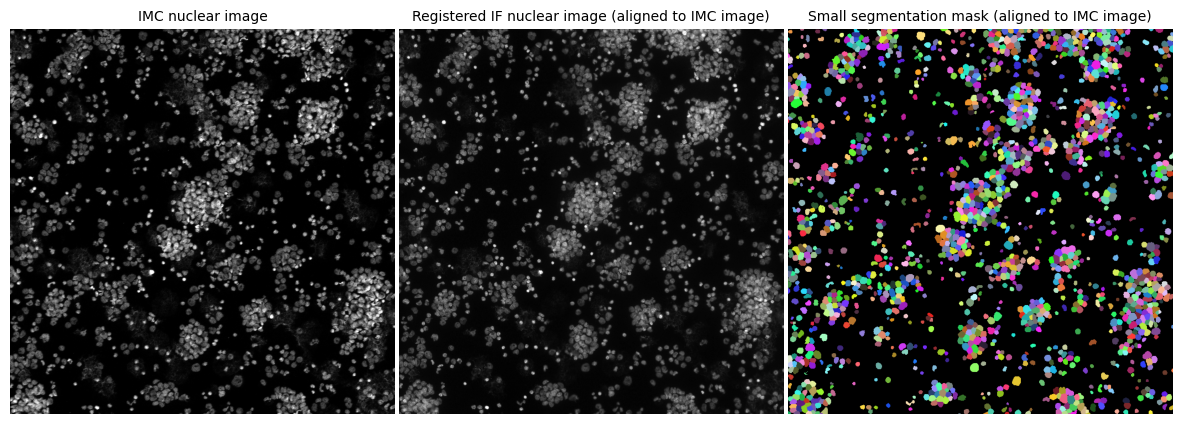

In [ ]:
import cv2

#Align segmentation mask to IMC nuclear image
small_segmentation_masks = registerer.warp(refined_segmentation_masks, IMC_nuclear_image.squeeze().shape, registerer.h_mov2fix, interpolation=cv2.INTER_NEAREST)

gridPlot([np.clip(IMC_nuclear_image, 0, np.percentile(IMC_nuclear_image, 99.9)), #clipping for better visualization
          IF_nuclear_image_registered, rand_col_seg(small_segmentation_masks)], 
          titles=["IMC nuclear image", "Registered IF nuclear image (aligned to IMC image)", "Small segmentation mask (aligned to IMC image)"], 
          grid_size=(1,3), plot_size=(15,6), hspace=0.0001, vspace=0.01)

Morphological features are however extracted from the high-resolution IF nuclear image. To this end, we align the IMC nuclear image to the IF nuclear image (keeping the latter fixed) using the inverted tranformation matrix ``h_fix2mov``. The segmentation matrix is then cropped according to the shape of the aligned IMC nuclear image. 

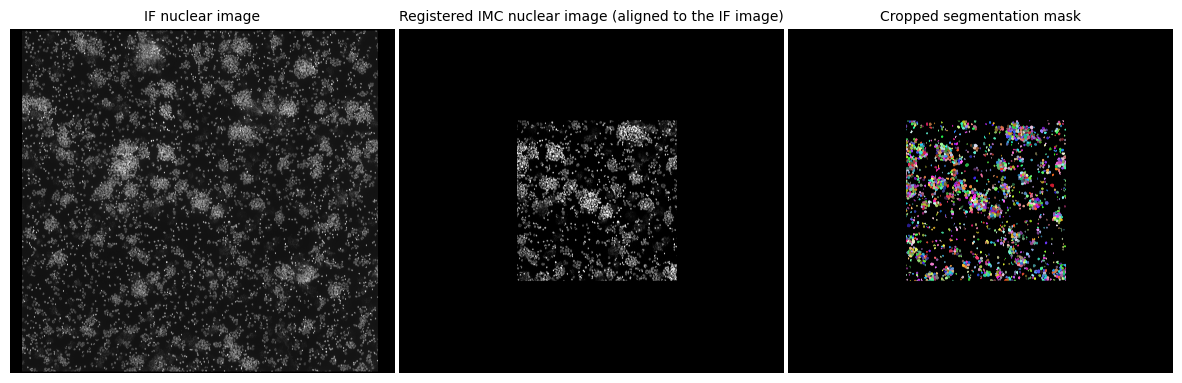

In [ ]:
#Align IMC nuclear image to segmentation mask and crop the latter
IMC_nuclear_image_registered = registerer.warp(IMC_nuclear_image, IF_nuclear_image.squeeze().shape, registerer.h_fix2mov)

tmp = np.ones_like(IMC_nuclear_image)
crop_template = registerer.warp(tmp, IF_nuclear_image.squeeze().shape, registerer.h_fix2mov)

idxs = np.where(crop_template != 0)
xmin, xmax = idxs[0].min(), idxs[0].max()
ymin, ymax = idxs[1].min(), idxs[1].max()

large_segmentation_masks = refined_segmentation_masks[xmin:xmax, ymin:ymax]

gridPlot([IF_nuclear_image, np.clip(IMC_nuclear_image_registered, 0, np.percentile(IMC_nuclear_image_registered, 99.9)), #clipping for better visualization 
          rand_col_seg(refined_segmentation_masks*np.asarray(crop_template, "uint16"))], 
          titles=["IF nuclear image", "Registered IMC nuclear image (aligned to the IF image)", "Cropped segmentation mask"], grid_size=(1,3), plot_size=(15,6), hspace=0.0001, vspace=0.01)

We then save the segmentation masks for later use.

In [ ]:
sample.data[roi] = {
    "large_segmentation_masks": large_segmentation_masks,
    "small_segmentation_masks": small_segmentation_masks
}

## Spillover compensation, Background correction and Normalization

Before we extract intensity features from the IF and IMC image channels, we perform spillover and background correction. 

### Spillover compensation

We generate the spillover matrix and perform the spillover correction by calling an R-based docker container as a subprocess. The ``spillover_folder`` contains spillover measurements for each channel in txt.files. The ``out_folder`` is reserved for saving the spillover_matrix and temporary files. 

In [ ]:
from MapMetIP.spillover import spillover_correction
import copy

sample_old = copy.deepcopy(sample)

#spillover compensation
spillover_folder = model_path.joinpath("spillover")
out_folder = model_path.joinpath("spillover/out")

sample = spillover_correction(sample, spillover_folder, out_folder, roi)

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


[1] "Generating Spillover Matrix ..."
Spotted channels:  Y89, In115, La139, Nd142, Nd143, Nd144, Nd145, Nd146, Sm147, Nd148, Sm149, Nd150, Eu151, Sm152, Eu153, Sm154, Gd155, Gd156, Gd158, Tb159, Gd160, Dy161, Dy162, Dy163, Dy164, Ho165, Er166, Er167, Er168, Tm169, Er170, Yb171, Yb172, Yb173, Yb174, Lu175, Yb176, Ir191, Ir193, Pt196, Bi209
Acquired channels:  Y89, In115, Xe131, Xe134, Ba136, La139, Nd142, Nd143, Nd144, Nd145, Nd146, Sm147, Nd148, Sm149, Nd150, Eu151, Sm152, Eu153, Sm154, Gd155, Gd156, Gd158, Tb159, Gd160, Dy161, Dy162, Dy163, Dy164, Ho165, Er166, Er167, Er168, Tm169, Er170, Yb171, Yb172, Yb173, Yb174, Lu175, Yb176, Ir191, Ir193, Pt196, Bi209
Channels spotted but not acquired:  
Channels acquired but not spotted:  Xe131, Xe134, Ba136

Debarcoding data...
 o ordering
 o classifying events
Normalizing...
Computing deltas...
Compensation is likely to be inaccurate.
Spill values for the following interactions
have not been estimated:
Xe131Di -> Xe134Di, Ba136Di, Sm147Di
Xe134Di -> Xe131Di, Ba136Di, Nd150Di
Ba136Di -> Xe134Di, Sm152Di


[1] "Compensating for 20220727_20220222_16-063_BM_1.tiff"


The difference between these two images is  177685.5 .


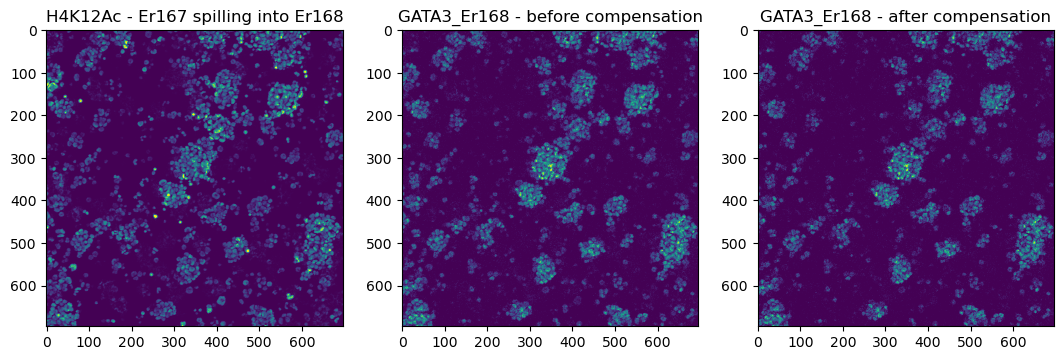

In [ ]:
#channel to visualize spillover
channel_IMC='GATA3_Er168'

#channel causing spillover
IMC_spill = sample_old.mod1[roi]
channel_idx = np.where(IMC_spill.stack_channels=='H4K12Ac_Er167')[0][0]
image_spill = IMC_spill.image_stack[channel_idx]

#before
IMC_old = sample_old.mod1[roi]
channel_idx = np.where(IMC_old.stack_channels==channel_IMC)[0][0]
image_before = IMC_old.image_stack[channel_idx]

#after
IMC = sample.mod1[roi]
channel_idx = np.where(IMC.stack_channels==channel_IMC)[0][0]
image_after = IMC.image_stack[channel_idx]

#plot images - clipping for visualization
fig, ax = plt.subplots(1, 3, figsize=(13, 13))
ax[0].imshow(np.clip(image_spill, 0, np.percentile(image_spill, 99.9)))
ax[1].imshow(np.clip(image_before, 0, np.percentile(image_before, 99.9)))
ax[2].imshow(np.clip(image_after, 0, np.percentile(image_after, 99.9)))

ax[0].set_title('H4K12Ac - Er167 spilling into Er168')
ax[1].set_title(channel_IMC + ' - before compensation')
ax[2].set_title(channel_IMC + ' - after compensation')

print("The difference between these two images is ", (image_before-image_after).sum(), ".")

After spillover compensation of the IMC images, we can stack the registered IF with the spillover-compensated IMC images.

In [ ]:
#Concatenate IMC and IF images into multi-channel image
all_pixelvalues = []

all_stack = np.concatenate((IMC.image_stack, IF.image_stack), axis=0)
all_channels = np.concatenate((IMC.stack_channels, IF.stack_channels))

all_pixelvalues.append(np.reshape(all_stack, (all_stack.shape[0], -1)))

sample.data[roi]["all_stack"] = all_stack
sample.data[roi]["all_channels"] = all_channels
        
setattr(sample, "all_channels", all_channels)
setattr(sample, "all_pixelvalues", np.concatenate(all_pixelvalues, axis=1))

### Hot pixel removal

We remove hot pixels using DIMR (differential intensity map-based restoration) function implemented in IMC-Denoise by [Lu et al.](https://www.nature.com/articles/s41467-023-37123-6#code-availability). 

In [ ]:
from IMC_Denoise.IMC_Denoise.IMC_Denoise_main.DIMR import DIMR

sample_old = copy.deepcopy(sample)

data = sample.data[roi]
    
hrm_stack = []
for image in data["all_stack"]:
    hrm_stack.append(DIMR(n_neighbours=4, n_iter=3, window_size=3).perform_DIMR(image))

sample.data[roi]["all_stack"] = np.array(hrm_stack)

Text(0.5, 1.0, 'DNA1_Ir193 - after DIMR hotpixel removal - zoom')

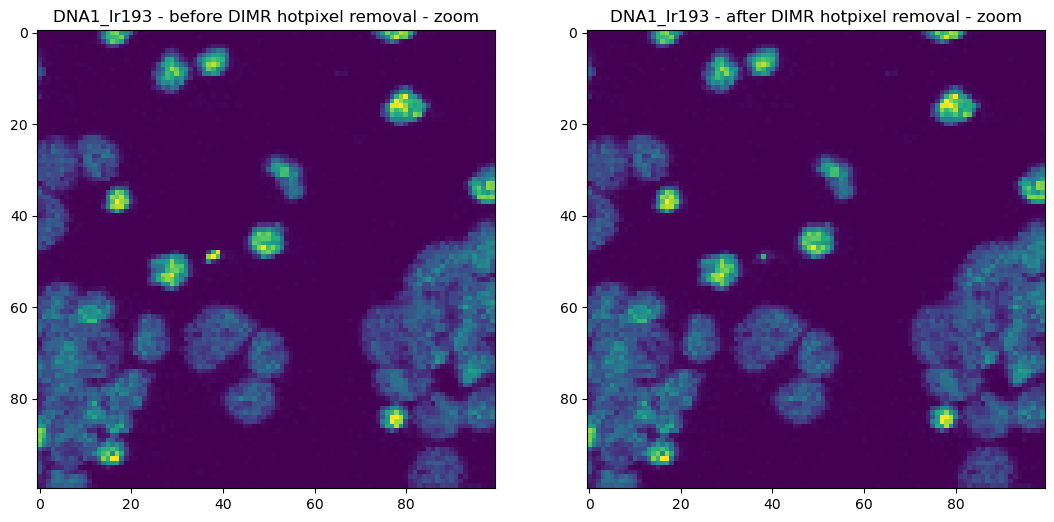

In [ ]:
#channel to visualize spillover
channel='DNA1_Ir193'

#before
stack_old = sample_old.data[roi]["all_stack"]
channel_idx = np.where(sample_old.all_channels==channel)[0][0]
image_before = stack_old[channel_idx]

#after
stack = sample.data[roi]["all_stack"]
channel_idx = np.where(sample.all_channels==channel)[0][0]
image_after = stack[channel_idx]

#plot images 
fig, ax = plt.subplots(1, 2, figsize=(13, 13))
ax[0].imshow(np.clip(image_before[350:450, 400:500], 0, np.percentile(image_before, 99.9)))
ax[1].imshow(np.clip(image_after[350:450, 400:500], 0, np.percentile(image_after, 99.9)))

ax[0].set_title(channel + ' - before DIMR hotpixel removal - zoom')
ax[1].set_title(channel + ' - after DIMR hotpixel removal - zoom')

### Background correction and normalization
Background correction is performed with the following steps:
- Clipping images to the 99.5th percentile (99th for HLA-ABC due to high number of staining artifacts) for outlier removal
- Background removal using classifier trained in Ilastik (1 classifier/marker)
- Min-max normalization between 0 and 1

In [ ]:
from MapMetIP.background_correction import BackgroundCorrecter
from MapMetIP.normalize import percentile_clip, minmax_sample

#Clip for outlier removal
sample = percentile_clip(sample)
sample_old = copy.deepcopy(sample)

#Background correction
backgroundcorrection_folder = model_path.joinpath("BM/BC_classifiers")

bc = BackgroundCorrecter(backgroundcorrection_folder)
data = sample.data[roi]
corrected, masks, new_channels = bc.correct(data["clipped_stack"], data["all_stack"], channels=data["all_channels"], keep_channels=sample.KEEP_CHANNELS)
sample.data[roi]["data_corrected"] = corrected
sample.data[roi]["data_channels"] = new_channels

sample = minmax_sample(sample)

Text(0.5, 1.0, 'CD44_In115 - after background correction')

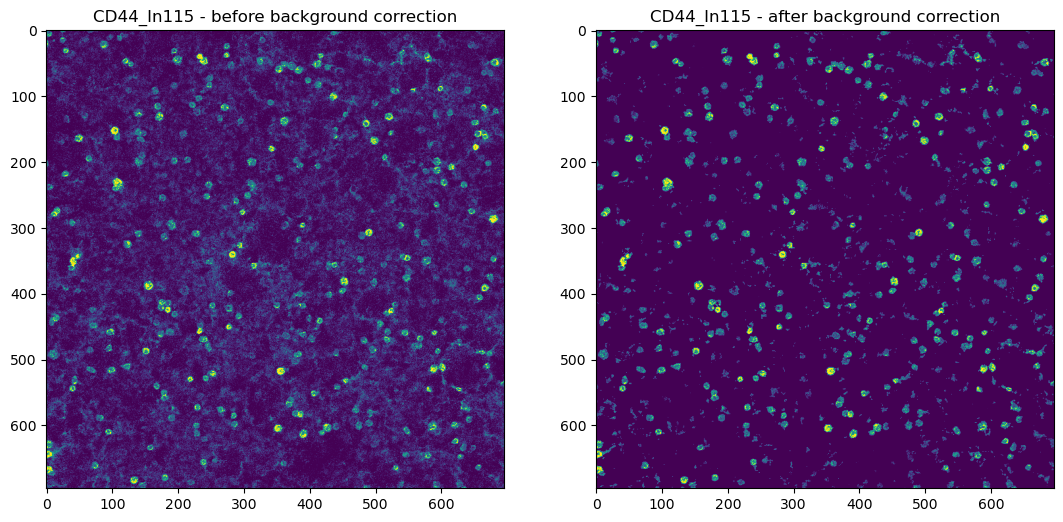

In [ ]:
#channel to visualize background correction
channel='CD44_In115'

#before
stack_old = sample_old.data[roi]["clipped_stack"]
channel_idx = np.where(sample_old.all_channels==channel)[0][0]
image_before = stack_old[channel_idx]

#after
stack = sample.data[roi]["data_minmax"]
channel_idx = np.where(sample.all_channels==channel)[0][0]
image_after = stack[channel_idx]

#plot images 
fig, ax = plt.subplots(1, 2, figsize=(13, 13))
ax[0].imshow(image_before)
ax[1].imshow(image_after)

ax[0].set_title(channel + ' - before background correction')
ax[1].set_title(channel + ' - after background correction')

## Extraction of intensity and morphological features

1. We export intensity features from the corrected IMC-IF image stacks using the registered, small segmentation masks as well as a dilated (by 1px) version of the latter.
2. Then, we export morphological features based on the cropped, large segmentation masks. 
3. Finally, we export cell neighbors based on ``CENTROID_DISTANCE``.

In [ ]:
from MapMetIP.feature_extraction import FeatureExtractor, extract_sample_features, MORPH_MEASURES
from MapMetIP.neighbors import extract_neighbors

featureextractor = FeatureExtractor(additional_morphology_functions=MORPH_MEASURES) 

sample = extract_sample_features(sample, featureextractor)
sample = extract_neighbors(sample, dmax=150)

100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


## Save images, masks and single-cell data

Finally, we save multi-channel IMC-IF images, registered segmentation masks and extracted single-cell data. 

In [ ]:
from MapMetIP.sample import save_sample

save_dir = Path(path2test_data).joinpath("MapMetIP_TestDataset/results")

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

save_sample(sample, save_dir)

1 dict_keys(['large_segmentation_masks', 'small_segmentation_masks', 'all_stack', 'all_channels', 'clipped_stack', 'data_corrected', 'data_channels', 'data_minmax', 'intensiy_features_0', 'intensiy_features_1', 'morphological_features', 'neighbors'])
